# Wine Quality Prediction: Tabular Foundation Models vs. Tree-Based Methods

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
hf_token = os.getenv("HFTOKEN")

os.environ["TABPFN_ALLOW_CPU_LARGE_DATASET"] = "1"

Shape: (4898, 12)
Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Dtypes:
 fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Missing values per column:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Head:
    fixed acidity  vo

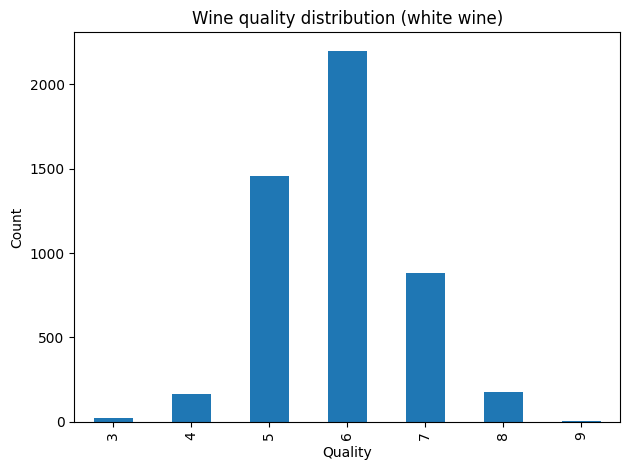

In [2]:
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)

from tabpfn import TabPFNRegressor, TabPFNClassifier
from tabicl import TabICLClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

path = "./data/winequality-white.csv"
#path = "./data/winequality-red.csv"
df = pd.read_csv(path, sep=";")

fname = os.path.basename(path).lower()
if "white" in fname:
    dataset_label = "white wine"
else:
    dataset_label = "red wine"

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 50)

print("\nHead:\n", df.head())
print("\nSummary stats:\n", df.describe(include="all").T)

target_col = "quality"
quality_counts = df[target_col].value_counts().sort_index()
print("\nQuality value counts:\n", quality_counts)

feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols]
y = df[target_col]

plt.figure()
quality_counts.plot(kind="bar")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.title(f"Wine quality distribution ({dataset_label})")
plt.tight_layout()
plt.show()

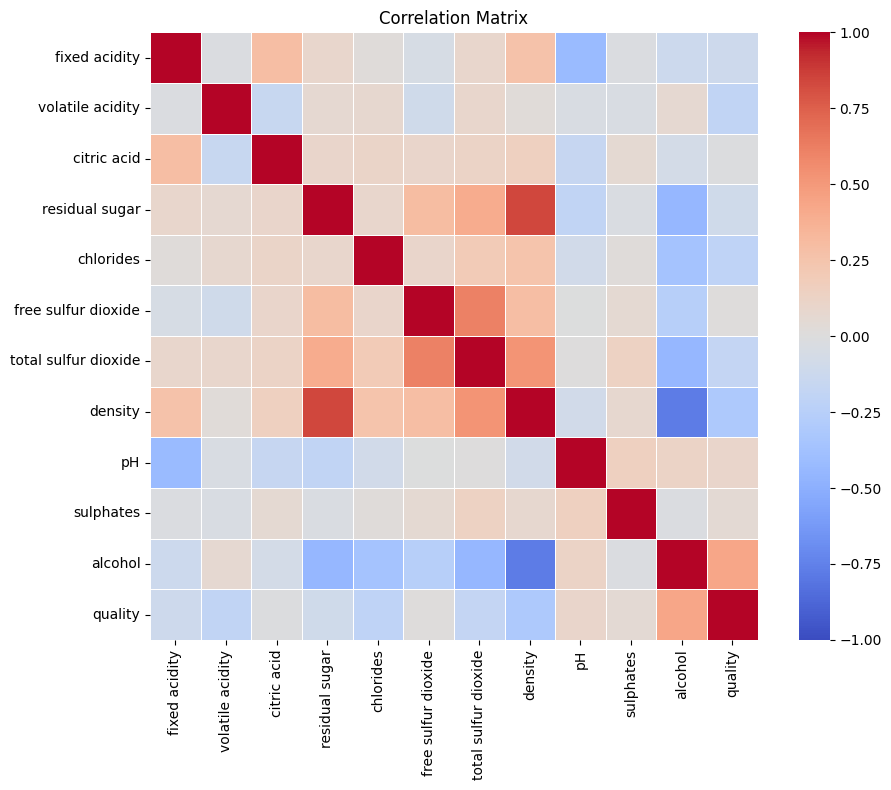

In [3]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    vmin=-1, vmax=1,
    cmap="coolwarm",
    annot=False,
    square=True,
    linewidths=0.5
)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


In [4]:
def timed_fit_predict(model, X_tr, y_tr, X_te):
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    model.fit(X_tr, y_tr)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    fit_s = time.perf_counter() - t0

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    y_hat = model.predict(X_te)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    pred_s = time.perf_counter() - t0

    return y_hat, fit_s, pred_s

### TabPFN (Regressor)

In [5]:
device = "cpu" # "cuda" or "cpu"

fold_summaries = []
all_y_true, all_y_pred = [], []

kf = KFold(n_splits=5, shuffle=True, random_state=21)

rmses, maes, r2s = [], [], []
fit_times, pred_times = [], []

warm_model = TabPFNRegressor(device=device)
_ = warm_model.fit(X.iloc[:256], y.iloc[:256])
_ = warm_model.predict(X.iloc[:256])
if torch.cuda.is_available():
    torch.cuda.synchronize()

for fold, (tr_idx, te_idx) in enumerate(kf.split(X), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

    model = TabPFNRegressor(device=device)
    y_hat, fit_s, pred_s = timed_fit_predict(model, X_tr, y_tr, X_te)

    rmse = root_mean_squared_error(y_te, y_hat)
    mae = mean_absolute_error(y_te, y_hat)
    r2 = r2_score(y_te, y_hat)

    rmses.append(rmse); maes.append(mae); r2s.append(r2)
    fit_times.append(fit_s); pred_times.append(pred_s)

    fold_summaries.append(
        {"fold": fold, "rmse": rmse, "mae": mae, "r2": r2, "fit_s": fit_s, "pred_s": pred_s}
    )
    all_y_true.append(y_te.to_numpy())
    all_y_pred.append(np.asarray(y_hat))

    print(f"Fold {fold}: RMSE={rmse:.4f} MAE={mae:.4f} R2={r2:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

print(
    f"\nTabPFN 5-fold CV: RMSE = {np.mean(rmses):.4f} ± {np.std(rmses):.4f}, "
    f"MAE = {np.mean(maes):.4f} ± {np.std(maes):.4f}, "
    f"R2 = {np.mean(r2s):.4f} ± {np.std(r2s):.4f}"
)
print(
    f"Timing: fit = {np.mean(fit_times):.2f}s ± {np.std(fit_times):.2f}, "
    f"predict = {np.mean(pred_times):.2f}s ± {np.std(pred_times):.2f}"
)

Fold 1: RMSE=0.5997 MAE=0.4385 R2=0.5171 | fit=0.414s pred=84.800s
Fold 2: RMSE=0.6080 MAE=0.4448 R2=0.5147 | fit=0.411s pred=85.662s
Fold 3: RMSE=0.6195 MAE=0.4660 R2=0.5064 | fit=0.400s pred=88.105s
Fold 4: RMSE=0.6235 MAE=0.4573 R2=0.5306 | fit=0.433s pred=80.695s
Fold 5: RMSE=0.6482 MAE=0.4608 R2=0.4796 | fit=0.365s pred=77.988s

TabPFN 5-fold CV: RMSE = 0.6198 ± 0.0165, MAE = 0.4535 ± 0.0102, R2 = 0.5097 ± 0.0169
Timing: fit = 0.40s ± 0.02, predict = 83.45s ± 3.63


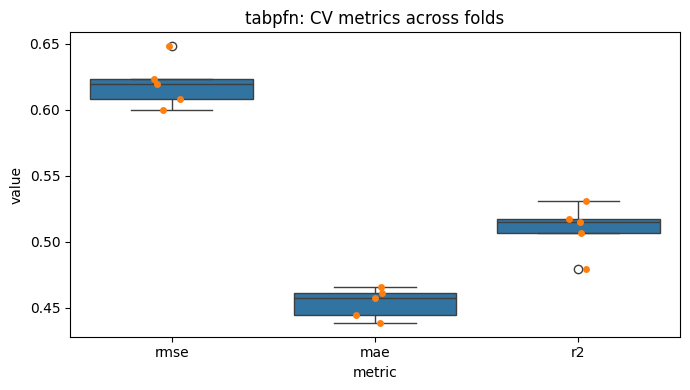

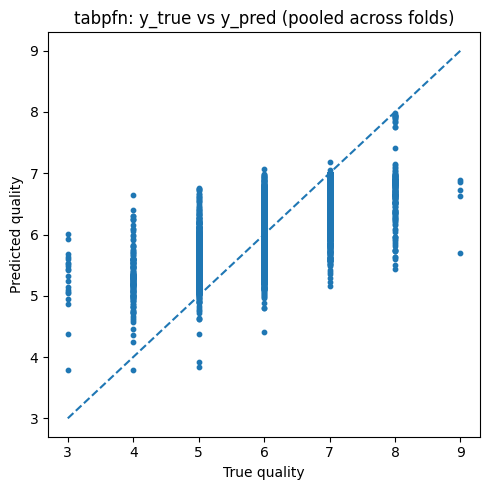

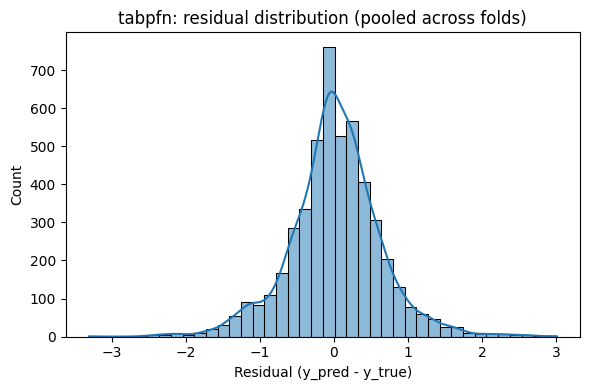

In [6]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

model_name = "tabpfn"

MODEL_RESULTS[model_name] = {
    "cv_metrics_df": pd.DataFrame(fold_summaries),
    "y_true_cv": np.concatenate(all_y_true).astype(float),
    "y_pred_cv": np.concatenate(all_y_pred).astype(float),
}

cv_metrics_df = MODEL_RESULTS[model_name]["cv_metrics_df"]
y_true_cv = MODEL_RESULTS[model_name]["y_true_cv"]
y_pred_cv = MODEL_RESULTS[model_name]["y_pred_cv"]

cv_metrics_long_df = cv_metrics_df.melt(
    id_vars=["fold"],
    value_vars=["rmse", "mae", "r2"],
    var_name="metric",
    value_name="value",
)

plt.figure(figsize=(7, 4))
sns.boxplot(data=cv_metrics_long_df, x="metric", y="value")
sns.stripplot(data=cv_metrics_long_df, x="metric", y="value", jitter=True, size=5)
plt.title(f"{model_name}: CV metrics across folds")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(y_true_cv, y_pred_cv, s=10)
mn = float(min(y_true_cv.min(), y_pred_cv.min()))
mx = float(max(y_true_cv.max(), y_pred_cv.max()))
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("True quality")
plt.ylabel("Predicted quality")
plt.title(f"{model_name}: y_true vs y_pred (pooled across folds)")
plt.tight_layout()
plt.show()

residuals_cv = y_pred_cv - y_true_cv
plt.figure(figsize=(6, 4))
sns.histplot(residuals_cv, bins=40, kde=True)
plt.xlabel("Residual (y_pred - y_true)")
plt.title(f"{model_name}: residual distribution (pooled across folds)")
plt.tight_layout()
plt.show()


## Plot Function

In [7]:
def plot_model_results(model_name):
    res = MODEL_RESULTS[model_name]
    cv_metrics_df = res["cv_metrics_df"]
    y_true_cv = res["y_true_cv"]
    y_pred_cv = res["y_pred_cv"]
    y_proba_cv = res["y_proba_cv"]
    dataset = res.get("dataset", "unknown dataset")

    metrics_long = cv_metrics_df.melt(
        id_vars=["fold"],
        value_vars=["acc", "auc"],
        var_name="metric",
        value_name="value",
    )
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=metrics_long, x="metric", y="value")
    sns.stripplot(data=metrics_long, x="metric", y="value", jitter=True, size=5)
    plt.title(f"{model_name} ({dataset}): CV metrics across folds")
    plt.tight_layout()
    plt.show()

    cm = confusion_matrix(y_true_cv, y_pred_cv)
    plt.figure(figsize=(4.5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} ({dataset}): Confusion matrix (pooled)")
    plt.tight_layout()
    plt.show()

    fpr, tpr, _ = roc_curve(y_true_cv, y_proba_cv)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title(f"{model_name} ({dataset}): ROC curve (pooled)")
    plt.tight_layout()
    plt.show()

    prec, rec, _ = precision_recall_curve(y_true_cv, y_proba_cv)
    ap = average_precision_score(y_true_cv, y_proba_cv)
    plt.figure(figsize=(5, 4))
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} ({dataset}): Precision–Recall curve (AP={ap:.3f})")
    plt.tight_layout()
    plt.show()

    bins = np.linspace(0.0, 1.0, 11)
    bin_ids = np.digitize(y_proba_cv, bins) - 1

    bin_centers, frac_pos = [], []
    for b in range(len(bins) - 1):
        m = bin_ids == b
        if m.sum() == 0:
            continue
        bin_centers.append((bins[b] + bins[b + 1]) / 2)
        frac_pos.append(y_true_cv[m].mean())

    plt.figure(figsize=(5, 4))
    plt.plot(bin_centers, frac_pos, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Predicted probability (bin center)")
    plt.ylabel("Empirical P(y=1)")
    plt.title(f"{model_name} ({dataset}): Reliability curve (pooled)")
    plt.tight_layout()
    plt.show()

### TabPFN (Classifier)

In [8]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

model_name = "tabpfn"
y_bin = (y >= 7).astype(int)

p = y_bin.mean()
print("Positive rate (quality>=7):", p)
print("Majority baseline accuracy:", max(p, 1 - p))

kf = KFold(n_splits=5, shuffle=True, random_state=20)

def get_pos_proba(model, X_):
    proba = model.predict_proba(X_)
    if hasattr(proba, "detach"):
        proba = proba.detach().cpu().numpy()
    if isinstance(proba, list):
        proba = np.asarray(proba)
    proba = np.asarray(proba)
    if proba.ndim == 2 and proba.shape[1] >= 2:
        return proba[:, 1]
    return proba.reshape(-1)

fold_summaries = []
all_y_true, all_y_pred, all_y_proba = [], [], []

warm_model = TabPFNClassifier(device=device)
_ = warm_model.fit(X.iloc[:256], y_bin.iloc[:256])
_ = get_pos_proba(warm_model, X.iloc[:256])
if torch.cuda.is_available():
    torch.cuda.synchronize()

for fold, (tr_idx, te_idx) in enumerate(kf.split(X), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

    model = TabPFNClassifier(device=device)

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    model.fit(X_tr, y_tr)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    fit_s = time.perf_counter() - t0

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    proba = get_pos_proba(model, X_te)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    pred_s = time.perf_counter() - t0

    y_hat = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_te, y_hat)
    auc = roc_auc_score(y_te, proba)

    fold_summaries.append({"fold": fold, "acc": acc, "auc": auc, "fit_s": fit_s, "pred_s": pred_s})
    all_y_true.append(y_te.to_numpy())
    all_y_pred.append(y_hat)
    all_y_proba.append(proba)

    print(f"Fold {fold}: ACC={acc:.4f} AUC={auc:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

cv_metrics_df = pd.DataFrame(fold_summaries)
y_true_cv = np.concatenate(all_y_true)
y_pred_cv = np.concatenate(all_y_pred)
y_proba_cv = np.concatenate(all_y_proba)

MODEL_RESULTS[model_name] = {
    "cv_metrics_df": cv_metrics_df,
    "y_true_cv": y_true_cv,
    "y_pred_cv": y_pred_cv,
    "y_proba_cv": y_proba_cv,
    "dataset": dataset_label,
}

print(
    f"\n{model_name} 5-fold CV: "
    f"ACC={cv_metrics_df['acc'].mean():.4f}±{cv_metrics_df['acc'].std():.4f}, "
    f"AUC={cv_metrics_df['auc'].mean():.4f}±{cv_metrics_df['auc'].std():.4f}"
)
print(
    f"Timing: fit={cv_metrics_df['fit_s'].mean():.2f}s±{cv_metrics_df['fit_s'].std():.2f}, "
    f"predict={cv_metrics_df['pred_s'].mean():.2f}s±{cv_metrics_df['pred_s'].std():.2f}"
)


Positive rate (quality>=7): 0.21641486320947326
Majority baseline accuracy: 0.7835851367905268
Fold 1: ACC=0.8847 AUC=0.9402 | fit=0.311s pred=82.408s
Fold 2: ACC=0.8745 AUC=0.9165 | fit=0.358s pred=84.526s
Fold 3: ACC=0.8949 AUC=0.9310 | fit=0.290s pred=79.898s
Fold 4: ACC=0.8723 AUC=0.9024 | fit=0.392s pred=78.418s
Fold 5: ACC=0.8784 AUC=0.9242 | fit=0.330s pred=77.082s

tabpfn 5-fold CV: ACC=0.8810±0.0091, AUC=0.9229±0.0144
Timing: fit=0.34s±0.04, predict=80.47s±3.01


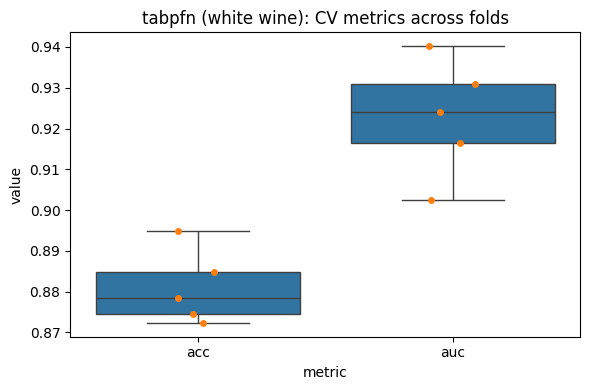

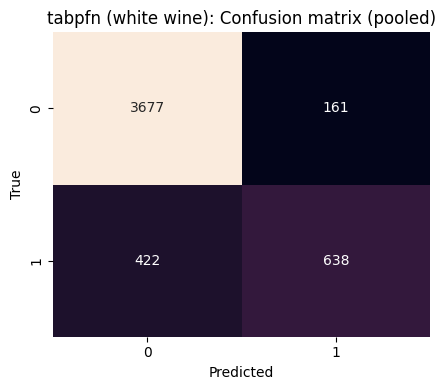

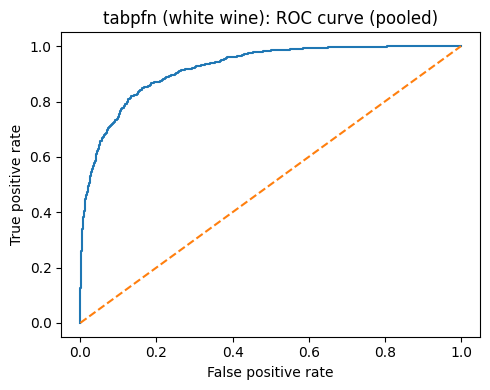

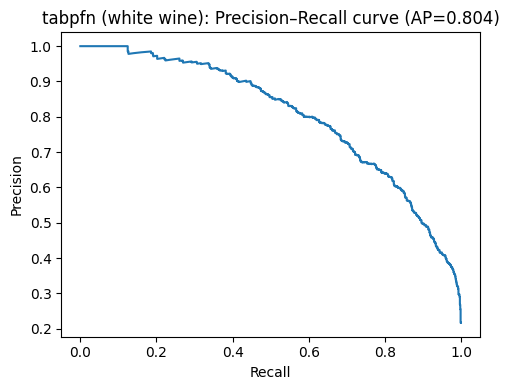

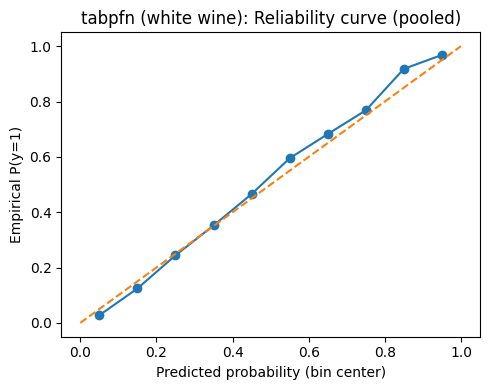

In [9]:
plot_model_results("tabpfn")

### TabICL

In [10]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

model_name = "tabicl"
y_bin = (y >= 7).astype(int)

p = y_bin.mean()
print("Positive rate (quality>=7):", p)
print("Majority baseline accuracy:", max(p, 1 - p))

kf = KFold(n_splits=5, shuffle=True, random_state=20)

def get_pos_proba(model, X_):
    proba = model.predict_proba(X_)
    if hasattr(proba, "detach"):
        proba = proba.detach().cpu().numpy()
    if isinstance(proba, list):
        proba = np.asarray(proba)
    proba = np.asarray(proba)
    if proba.ndim == 2 and proba.shape[1] >= 2:
        return proba[:, 1]
    return proba.reshape(-1)

fold_summaries = []
all_y_true, all_y_pred, all_y_proba = [], [], []

warm_model = TabICLClassifier(device=device)
_ = warm_model.fit(X.iloc[:256], y_bin.iloc[:256])
_ = get_pos_proba(warm_model, X.iloc[:256])
if torch.cuda.is_available():
    torch.cuda.synchronize()

for fold, (tr_idx, te_idx) in enumerate(kf.split(X), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

    model = TabICLClassifier(device=device)

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    model.fit(X_tr, y_tr)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    fit_s = time.perf_counter() - t0

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    proba = get_pos_proba(model, X_te)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    pred_s = time.perf_counter() - t0

    y_hat = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_te, y_hat)
    auc = roc_auc_score(y_te, proba)

    fold_summaries.append({"fold": fold, "acc": acc, "auc": auc, "fit_s": fit_s, "pred_s": pred_s})
    all_y_true.append(y_te.to_numpy())
    all_y_pred.append(y_hat)
    all_y_proba.append(proba)

    print(f"Fold {fold}: ACC={acc:.4f} AUC={auc:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

cv_metrics_df = pd.DataFrame(fold_summaries)
y_true_cv = np.concatenate(all_y_true)
y_pred_cv = np.concatenate(all_y_pred)
y_proba_cv = np.concatenate(all_y_proba)

MODEL_RESULTS[model_name] = {
    "cv_metrics_df": cv_metrics_df,
    "y_true_cv": y_true_cv,
    "y_pred_cv": y_pred_cv,
    "y_proba_cv": y_proba_cv,
    "dataset": dataset_label,
}

print(
    f"\n{model_name} 5-fold CV: "
    f"ACC={cv_metrics_df['acc'].mean():.4f}±{cv_metrics_df['acc'].std():.4f}, "
    f"AUC={cv_metrics_df['auc'].mean():.4f}±{cv_metrics_df['auc'].std():.4f}"
)
print(
    f"Timing: fit={cv_metrics_df['fit_s'].mean():.2f}s±{cv_metrics_df['fit_s'].std():.2f}, "
    f"predict={cv_metrics_df['pred_s'].mean():.2f}s±{cv_metrics_df['pred_s'].std():.2f}"
)


Positive rate (quality>=7): 0.21641486320947326
Majority baseline accuracy: 0.7835851367905268
Fold 1: ACC=0.8939 AUC=0.9458 | fit=0.386s pred=102.933s
Fold 2: ACC=0.8786 AUC=0.9290 | fit=0.448s pred=105.234s
Fold 3: ACC=0.8990 AUC=0.9375 | fit=0.413s pred=103.714s
Fold 4: ACC=0.8754 AUC=0.9127 | fit=0.370s pred=114.407s
Fold 5: ACC=0.8805 AUC=0.9335 | fit=0.478s pred=113.802s

tabicl 5-fold CV: ACC=0.8855±0.0103, AUC=0.9317±0.0123
Timing: fit=0.42s±0.04, predict=108.02s±5.62


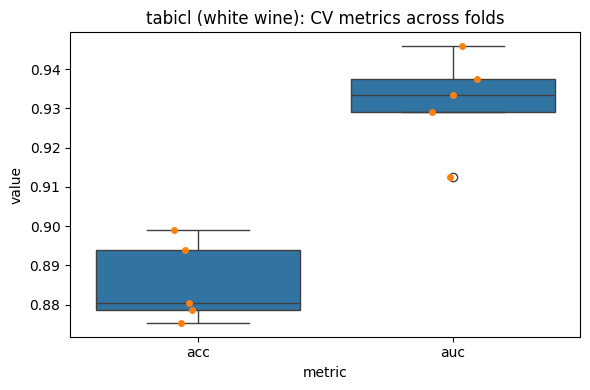

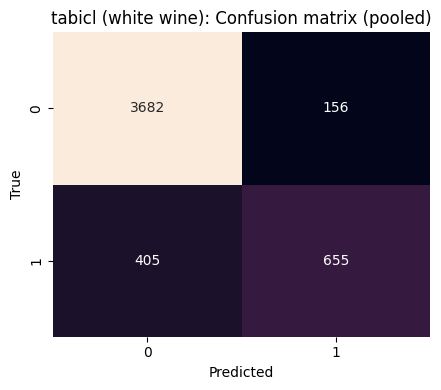

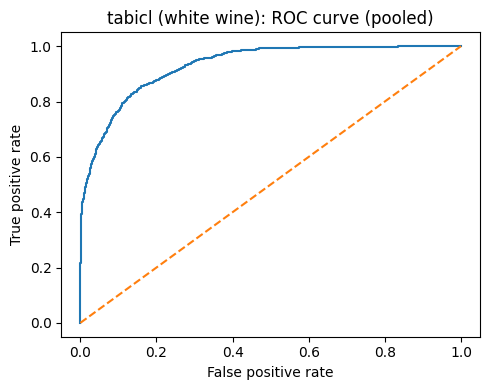

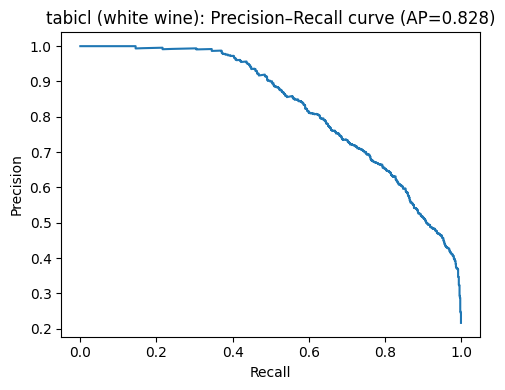

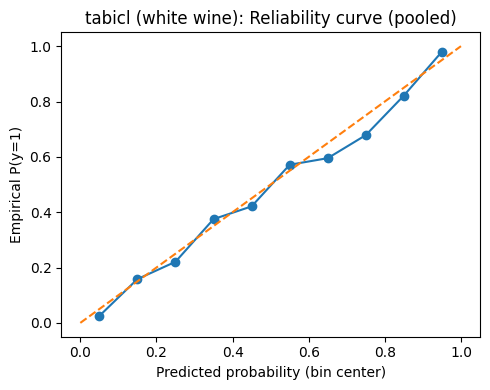

In [11]:
plot_model_results("tabicl")

### Random Forest, XGBoost, CatBoost and LightGBM

In [12]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

y_bin = (y >= 7).astype(int)

p = y_bin.mean()
print("Positive rate (quality>=7):", p)
print("Majority baseline accuracy:", max(p, 1 - p))
print(55 * "-")

kf = KFold(n_splits=5, shuffle=True, random_state=20)

def _get_pos_proba(model, X_te):
    proba = model.predict_proba(X_te)
    if hasattr(proba, "detach"):
        proba = proba.detach().cpu().numpy()
    if isinstance(proba, list):
        proba = np.asarray(proba)
    proba = np.asarray(proba)
    if proba.ndim == 2 and proba.shape[1] >= 2:
        return proba[:, 1]
    return proba.reshape(-1)

def run_cv(model_name, make_model):
    fold_summaries = []
    all_y_true, all_y_pred, all_y_proba = [], [], []

    warm = make_model()
    warm.fit(X.iloc[:256], y_bin.iloc[:256])
    _ = _get_pos_proba(warm, X.iloc[:256])

    for fold, (tr_idx, te_idx) in enumerate(kf.split(X), 1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

        model = make_model()

        t0 = time.perf_counter()
        model.fit(X_tr, y_tr)
        fit_s = time.perf_counter() - t0

        t0 = time.perf_counter()
        proba = _get_pos_proba(model, X_te)
        pred_s = time.perf_counter() - t0

        y_hat = (proba >= 0.5).astype(int)

        acc = accuracy_score(y_te, y_hat)
        auc = roc_auc_score(y_te, proba)

        fold_summaries.append({"fold": fold, "acc": acc, "auc": auc, "fit_s": fit_s, "pred_s": pred_s})
        all_y_true.append(y_te.to_numpy())
        all_y_pred.append(y_hat)
        all_y_proba.append(proba)

        print(f"{model_name} Fold {fold}: ACC={acc:.4f} AUC={auc:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

    cv_metrics_df = pd.DataFrame(fold_summaries)
    y_true_cv = np.concatenate(all_y_true)
    y_pred_cv = np.concatenate(all_y_pred)
    y_proba_cv = np.concatenate(all_y_proba)

    MODEL_RESULTS[model_name] = {
        "cv_metrics_df": cv_metrics_df,
        "y_true_cv": y_true_cv,
        "y_pred_cv": y_pred_cv,
        "y_proba_cv": y_proba_cv,
        "dataset": dataset_label,
    }

    print(
        f"\n{model_name} 5-fold CV: "
        f"ACC={cv_metrics_df['acc'].mean():.4f}±{cv_metrics_df['acc'].std():.4f}, "
        f"AUC={cv_metrics_df['auc'].mean():.4f}±{cv_metrics_df['auc'].std():.4f}"
    )
    print(
        f"Timing: fit={cv_metrics_df['fit_s'].mean():.2f}s±{cv_metrics_df['fit_s'].std():.2f}, "
        f"predict={cv_metrics_df['pred_s'].mean():.2f}s±{cv_metrics_df['pred_s'].std():.2f}"
    )
    print(55 * "-")

models_to_run = {}

models_to_run["rf"] = lambda: RandomForestClassifier(random_state=20, n_jobs=-1)

models_to_run["xgb"] = lambda: XGBClassifier(random_state=20, n_jobs=-1)

models_to_run["cat"] = lambda: CatBoostClassifier(random_seed=20, verbose=False)

models_to_run["lgbm"] = lambda: LGBMClassifier(random_state=20, n_jobs=-1, verbose=-1)

for name, factory in models_to_run.items():
    run_cv(name, factory)

Positive rate (quality>=7): 0.21641486320947326
Majority baseline accuracy: 0.7835851367905268
-------------------------------------------------------
rf Fold 1: ACC=0.8867 AUC=0.9311 | fit=0.302s pred=0.052s
rf Fold 2: ACC=0.8735 AUC=0.9163 | fit=0.279s pred=0.052s
rf Fold 3: ACC=0.8888 AUC=0.9158 | fit=0.280s pred=0.053s
rf Fold 4: ACC=0.8764 AUC=0.9003 | fit=0.283s pred=0.051s
rf Fold 5: ACC=0.8815 AUC=0.9187 | fit=0.283s pred=0.050s

rf 5-fold CV: ACC=0.8814±0.0065, AUC=0.9164±0.0110
Timing: fit=0.29s±0.01, predict=0.05s±0.00
-------------------------------------------------------
xgb Fold 1: ACC=0.8929 AUC=0.9127 | fit=0.047s pred=0.002s
xgb Fold 2: ACC=0.8561 AUC=0.8870 | fit=0.044s pred=0.002s
xgb Fold 3: ACC=0.8806 AUC=0.9144 | fit=0.049s pred=0.002s
xgb Fold 4: ACC=0.8539 AUC=0.8773 | fit=0.045s pred=0.002s
xgb Fold 5: ACC=0.8672 AUC=0.8978 | fit=0.049s pred=0.002s

xgb 5-fold CV: ACC=0.8701±0.0165, AUC=0.8979±0.0161
Timing: fit=0.05s±0.00, predict=0.00s±0.00
-----------------

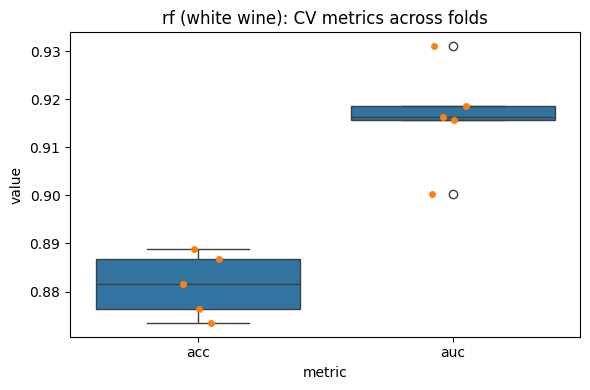

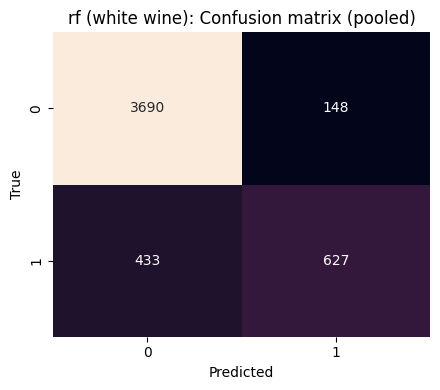

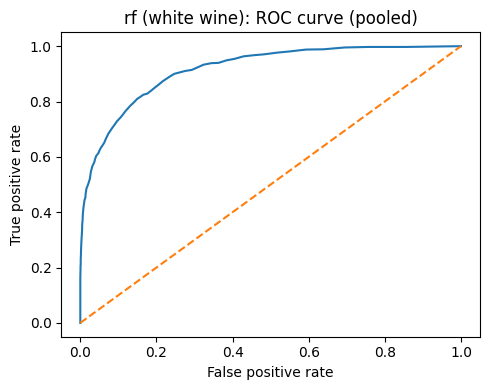

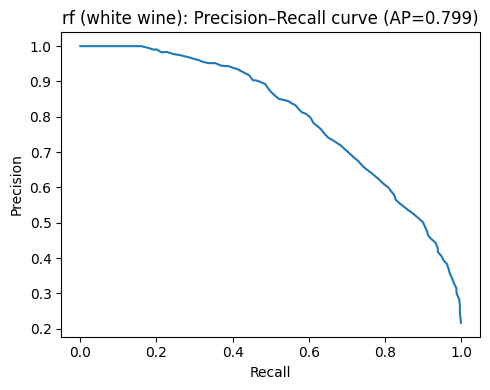

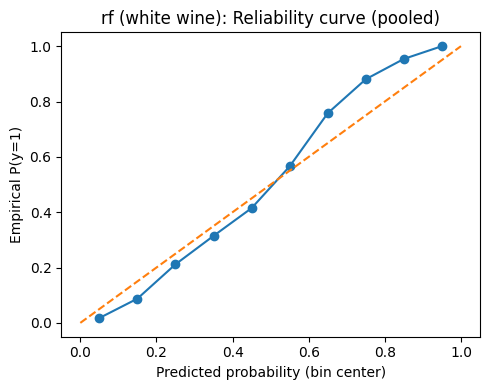

In [13]:
plot_model_results("rf")

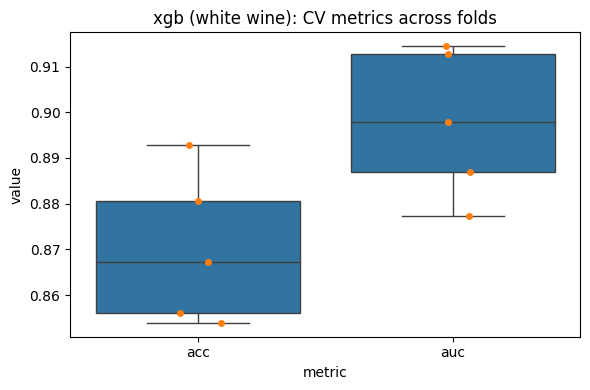

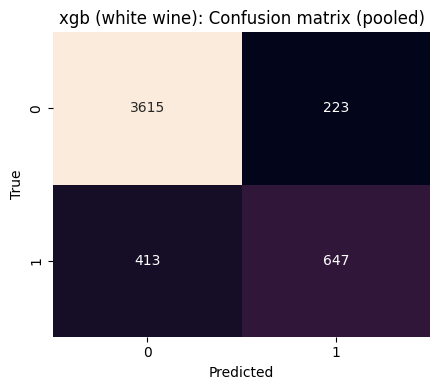

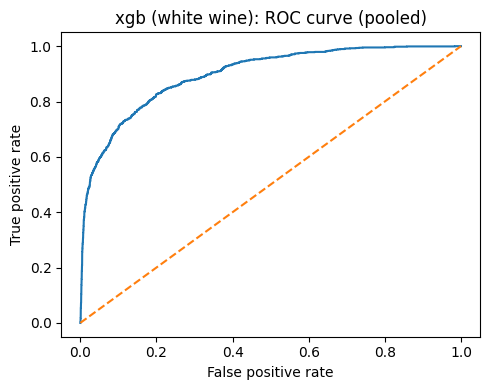

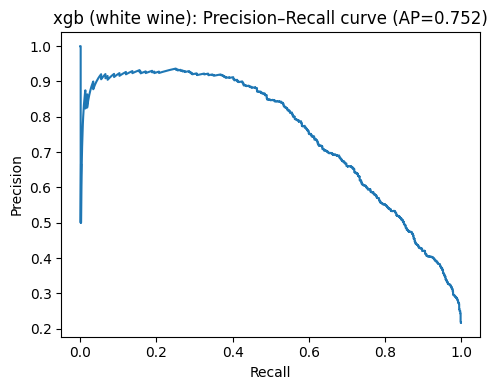

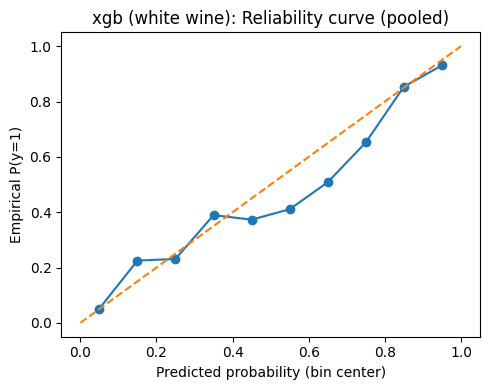

In [14]:
plot_model_results("xgb")

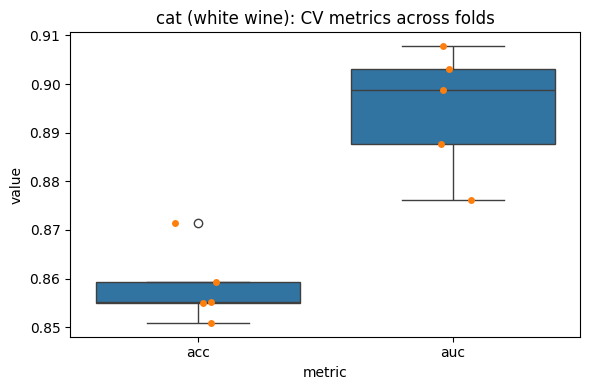

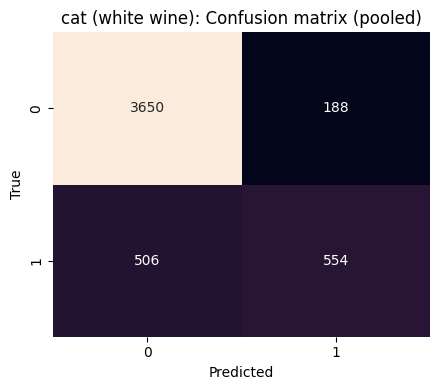

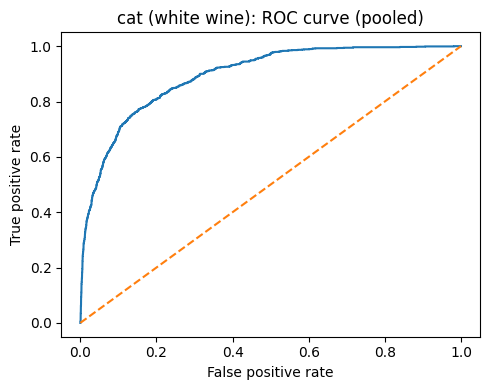

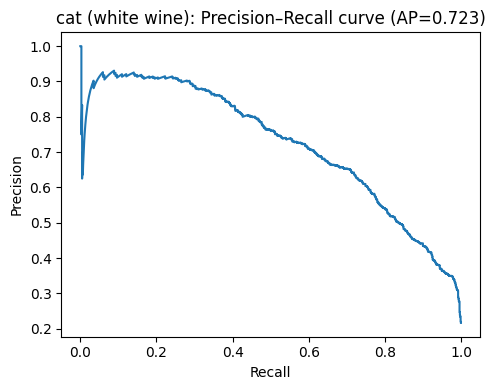

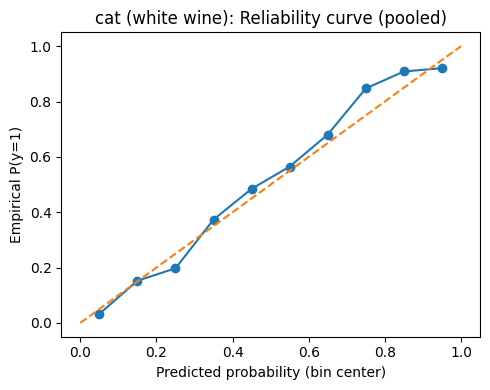

In [15]:
plot_model_results("cat")

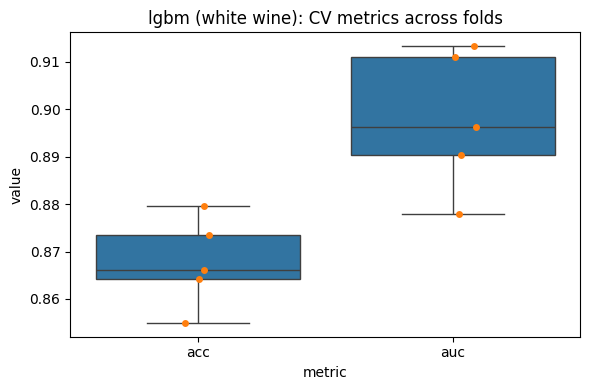

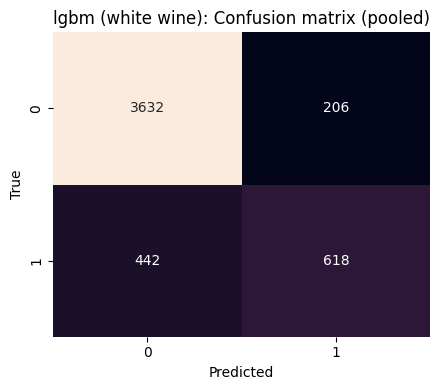

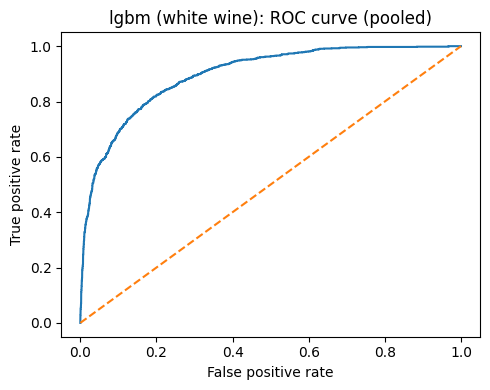

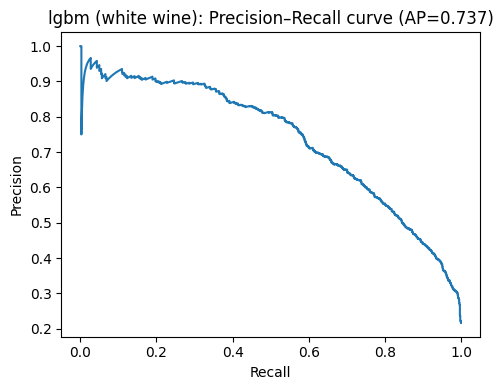

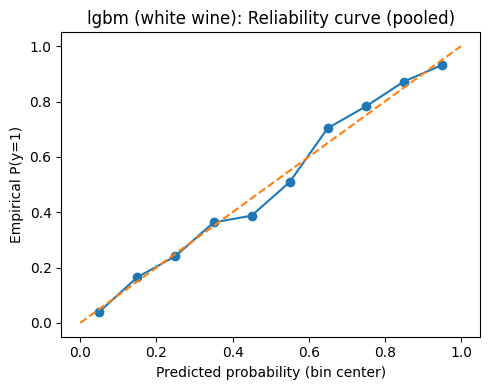

In [16]:
plot_model_results("lgbm")

In [17]:
rows = []
for name, res in MODEL_RESULTS.items():
    cv = res.get("cv_metrics_df", None)
    if cv is None or cv.empty:
        continue
    rows.append({
        "model": name,
        "acc_mean": cv["acc"].mean(),
        "acc_std": cv["acc"].std(ddof=1),
        "auc_mean": cv["auc"].mean(),
        "auc_std": cv["auc"].std(ddof=1),
        "fit_s_mean": cv["fit_s"].mean() if "fit_s" in cv.columns else None,
        "pred_s_mean": cv["pred_s"].mean() if "pred_s" in cv.columns else None,
        "n_folds": int(cv.shape[0]),
    })

summary_df = pd.DataFrame(rows).sort_values("auc_mean", ascending=False).reset_index(drop=True)

for c in ["acc_mean", "acc_std", "auc_mean", "auc_std", "fit_s_mean", "pred_s_mean"]:
    if c in summary_df.columns:
        summary_df[c] = summary_df[c].astype(float)

display(summary_df.style.format({
    "acc_mean": "{:.4f}",
    "acc_std": "{:.4f}",
    "auc_mean": "{:.4f}",
    "auc_std": "{:.4f}",
    "fit_s_mean": "{:.3f}",
    "pred_s_mean": "{:.3f}",
}))


,model,acc_mean,acc_std,auc_mean,auc_std,fit_s_mean,pred_s_mean,n_folds
0,tabicl,0.8853,0.0105,0.9317,0.0123,0.518,2.881,5
1,tabpfn,0.8808,0.0093,0.9229,0.0144,0.247,1.938,5
2,rf,0.8814,0.0065,0.9164,0.0110,0.286,0.052,5
3,xgb,0.8701,0.0165,0.8979,0.0161,0.047,0.002,5
4,lgbm,0.8677,0.0094,0.8978,0.0147,0.082,0.002,5
5,cat,0.8583,0.0079,0.8947,0.0128,2.326,0.002,5


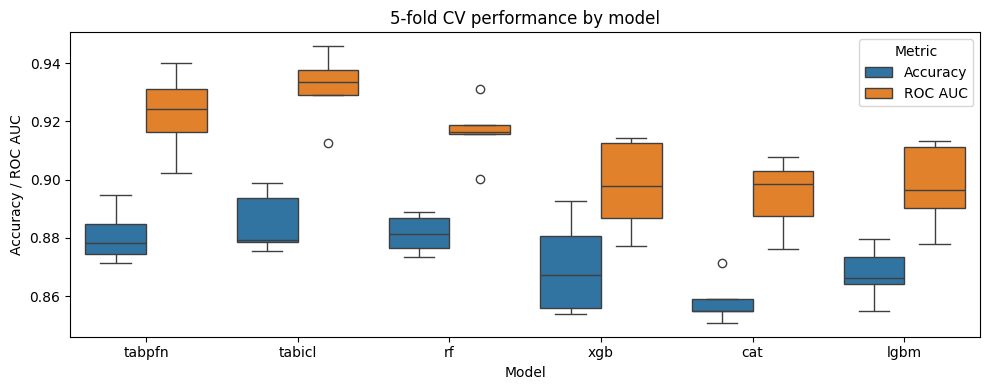

In [18]:

rows = []
for name, res in MODEL_RESULTS.items():
    cv = res.get("cv_metrics_df")
    if cv is None or cv.empty:
        continue
    tmp = cv.copy()
    tmp["model"] = name
    rows.append(tmp)

cv_all = pd.concat(rows, ignore_index=True)

m_long = cv_all.melt(
    id_vars=["model", "fold"],
    value_vars=["acc", "auc"],
    var_name="metric",
    value_name="value",
)

metric_names = {"acc": "Accuracy", "auc": "ROC AUC"}
m_long["metric"] = m_long["metric"].map(metric_names)

plt.figure(figsize=(10, 4))
ax = sns.boxplot(data=m_long, x="model", y="value", hue="metric")

ax.set_xlabel("Model")
ax.set_ylabel("Accuracy / ROC AUC")
ax.set_title("5-fold CV performance by model")

ax.legend(title="Metric", loc="upper right", frameon=True)

plt.tight_layout()
plt.show()


### Optuna optimization

In [19]:
def _cv_auc_for_model(make_model, trial=None):
    aucs = []
    for fold, (tr_idx, te_idx) in enumerate(kf.split(X), 1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

        model = make_model()
        model.fit(X_tr, y_tr)
        proba = _get_pos_proba(model, X_te)
        auc = roc_auc_score(y_te, proba)
        aucs.append(auc)

        if trial is not None:
            trial.report(float(np.mean(aucs)), step=fold)
            if trial.should_prune():
                raise optuna.TrialPruned()

    return float(np.mean(aucs))

def optuna_optimize(model_key, objective_fn, n_trials=40, seed=20, timeout=None):
    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(seed=seed),
        pruner=MedianPruner(n_warmup_steps=2),
    )
    study.optimize(objective_fn, n_trials=n_trials, timeout=timeout, show_progress_bar=True)

    MODEL_RESULTS[f"{model_key}_optuna"] = {
        "best_value": study.best_value,
        "best_params": study.best_params,
        "study": study,
    }

    print(f"{model_key} Optuna best mean AUC = {study.best_value:.4f}")
    print("Best params:", study.best_params)
    return study.best_params

In [20]:
def rf_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 120, 500),
        "max_depth": trial.suggest_int("max_depth", 8, 16),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 12),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 8),
        "max_features": trial.suggest_categorical("max_features", ["log2"]),
        "bootstrap": True,
        "max_samples": trial.suggest_float("max_samples", 0.8, 1.0),
        "class_weight": trial.suggest_categorical("class_weight", [None]),
    }

    def make_model():
        return RandomForestClassifier(random_state=20, n_jobs=-1, **params)

    return _cv_auc_for_model(make_model, trial=trial)

best_rf = optuna_optimize("rf", rf_objective, n_trials=50, seed=20)
run_cv("rf_opt", lambda: RandomForestClassifier(random_state=20, n_jobs=-1, **best_rf))


[I 2026-02-01 15:00:04,023] A new study created in memory with name: no-name-102a2310-cbda-442d-b06b-14578c716ee2


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-01 15:00:09,377] Trial 0 finished with value: 0.88840269084186 and parameters: {'n_estimators': 344, 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 'log2', 'max_samples': 0.8071779171233707, 'class_weight': None}. Best is trial 0 with value: 0.88840269084186.
[I 2026-02-01 15:00:15,299] Trial 1 finished with value: 0.8895789051808144 and parameters: {'n_estimators': 383, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'log2', 'max_samples': 0.8387700435765897, 'class_weight': None}. Best is trial 1 with value: 0.8895789051808144.
[I 2026-02-01 15:00:18,792] Trial 2 finished with value: 0.8906450339499852 and parameters: {'n_estimators': 223, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'log2', 'max_samples': 0.9550489787988725, 'class_weight': None}. Best is trial 2 with value: 0.8906450339499852.
[I 2026-02-01 15:00:20,918] Trial 3 finished with value: 0.8871851471229123 an

In [21]:
# optional: helps with imbalance sometimes
scale_pos_weight = float((y_bin == 0).sum() / max(1, (y_bin == 1).sum()))

def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 3e-1, log=True),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.5, 10.0, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 3.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 1e2, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-6, 1e1, log=True),
    }

    def make_model():
        return XGBClassifier(
            random_state=20,
            n_jobs=-1,
            eval_metric="logloss",
            tree_method="hist",
            # scale_pos_weight=scale_pos_weight,
            **params,
        )

    return _cv_auc_for_model(make_model, trial=trial)

best_xgb = optuna_optimize("xgb", xgb_objective, n_trials=80, seed=20)
run_cv("xgb_opt", lambda: XGBClassifier(
    random_state=20, n_jobs=-1, eval_metric="logloss", tree_method="hist", **best_xgb
))

[I 2026-02-01 15:04:28,603] A new study created in memory with name: no-name-37d6202b-adc3-4360-95bd-6ac9fb3436bc


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2026-02-01 15:04:29,223] Trial 0 finished with value: 0.8935768042609963 and parameters: {'n_estimators': 788, 'max_depth': 9, 'learning_rate': 0.1615956698742364, 'subsample': 0.9447512431923052, 'colsample_bytree': 0.7107668756850559, 'min_child_weight': 3.971617063672533, 'gamma': 1.1360428260162245, 'reg_lambda': 0.3913404384439021, 'reg_alpha': 0.04033297516098402}. Best is trial 0 with value: 0.8935768042609963.
[I 2026-02-01 15:04:29,813] Trial 1 finished with value: 0.8863027558099033 and parameters: {'n_estimators': 394, 'max_depth': 4, 'learning_rate': 0.06026623099859884, 'subsample': 0.9349010828377031, 'colsample_bytree': 0.9550982919324986, 'min_child_weight': 5.100195989404581, 'gamma': 0.10999291926325727, 'reg_lambda': 0.0038323809760880366, 'reg_alpha': 0.18153689223989536}. Best is trial 0 with value: 0.8935768042609963.
[I 2026-02-01 15:04:30,173] Trial 2 finished with value: 0.8725701558580399 and parameters: {'n_estimators': 439, 'max_depth': 4, 'learning_rate'

In [22]:
def cat_objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 300, 2600),
        "depth": trial.suggest_int("depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 3e-1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 1e2, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.1, 2.0),
    }

    def make_model():
        return CatBoostClassifier(
            random_seed=20,
            verbose=False,
            loss_function="Logloss",
            **params,
        )

    return _cv_auc_for_model(make_model, trial=trial)

best_cat = optuna_optimize("cat", cat_objective, n_trials=50, seed=20)
run_cv("cat_opt", lambda: CatBoostClassifier(random_seed=20, verbose=False, loss_function="Logloss", **best_cat))


[I 2026-02-01 15:06:38,369] A new study created in memory with name: no-name-0c628178-05f5-4afe-90d9-6f51e86d99f6


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-01 15:08:19,590] Trial 0 finished with value: 0.9150977474940076 and parameters: {'iterations': 1653, 'depth': 10, 'learning_rate': 0.1615956698742364, 'l2_leaf_reg': 18.337913052456294, 'random_strength': 0.0013917407466453636, 'bagging_temperature': 1.4143394053418794}. Best is trial 0 with value: 0.9150977474940076.
[I 2026-02-01 15:08:35,153] Trial 1 finished with value: 0.913959205955706 and parameters: {'iterations': 1171, 'depth': 7, 'learning_rate': 0.04264082119338054, 'l2_leaf_reg': 0.059621221782989314, 'random_strength': 0.012281901449602199, 'bagging_temperature': 1.465351273842215}. Best is trial 0 with value: 0.9150977474940076.
[I 2026-02-01 15:09:27,279] Trial 2 finished with value: 0.9135771436201517 and parameters: {'iterations': 2101, 'depth': 9, 'learning_rate': 0.08324834426314268, 'l2_leaf_reg': 0.014017069467775955, 'random_strength': 0.002929374795401813, 'bagging_temperature': 1.5274333290266318}. Best is trial 0 with value: 0.9150977474940076.
[I 2

In [23]:
def lgbm_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 3e-1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 255),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 150),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 1e2, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
    }

    def make_model():
        return LGBMClassifier(
            random_state=20,
            n_jobs=-1,
            verbose=-1,
            **params,
        )

    return _cv_auc_for_model(make_model, trial=trial)

best_lgbm = optuna_optimize("lgbm", lgbm_objective, n_trials=80, seed=20)
run_cv("lgbm_opt", lambda: LGBMClassifier(random_state=20, n_jobs=-1, verbose=-1, **best_lgbm))


[I 2026-02-01 15:51:11,467] A new study created in memory with name: no-name-93a4aa98-ee30-4f11-818e-1df2cf69b90d


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2026-02-01 15:51:12,361] Trial 0 finished with value: 0.8797855060035301 and parameters: {'n_estimators': 1847, 'learning_rate': 0.16739626207550662, 'num_leaves': 229, 'min_child_samples': 124, 'subsample': 0.6143558342467413, 'colsample_bytree': 0.8767030327035535, 'reg_lambda': 0.07823565268282258, 'min_split_gain': 0.5185109454480806}. Best is trial 0 with value: 0.8797855060035301.
[I 2026-02-01 15:51:19,711] Trial 1 finished with value: 0.874324493643762 and parameters: {'n_estimators': 2042, 'learning_rate': 0.0030212766548947654, 'num_leaves': 80, 'min_child_samples': 109, 'subsample': 0.9132014437836042, 'colsample_bytree': 0.9401310559099981, 'reg_lambda': 7.52011479151006, 'min_split_gain': 0.03666430642108576}. Best is trial 0 with value: 0.8797855060035301.
[I 2026-02-01 15:51:20,961] Trial 2 finished with value: 0.9028242854135439 and parameters: {'n_estimators': 526, 'learning_rate': 0.07261283430630519, 'num_leaves': 72, 'min_child_samples': 42, 'subsample': 0.943050


=== rf_opt using rf_optuna best params ===
{'n_estimators': 469, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_samples': 0.9800498959447399, 'class_weight': None}
rf_opt Fold 1: ACC=0.8929 AUC=0.9316 | fit=1.309s pred=0.207s
rf_opt Fold 2: ACC=0.8765 AUC=0.9200 | fit=1.281s pred=0.210s
rf_opt Fold 3: ACC=0.9010 AUC=0.9188 | fit=1.277s pred=0.209s
rf_opt Fold 4: ACC=0.8713 AUC=0.8974 | fit=1.299s pred=0.209s
rf_opt Fold 5: ACC=0.8866 AUC=0.9208 | fit=1.339s pred=0.209s

rf_opt 5-fold CV: ACC=0.8857±0.0120, AUC=0.9177±0.0125
Timing: fit=1.30s±0.03, predict=0.21s±0.00
-------------------------------------------------------


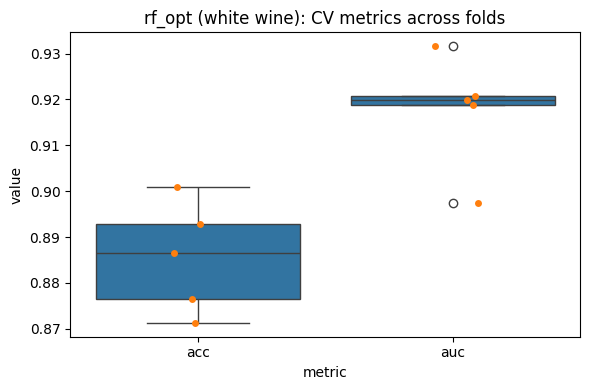

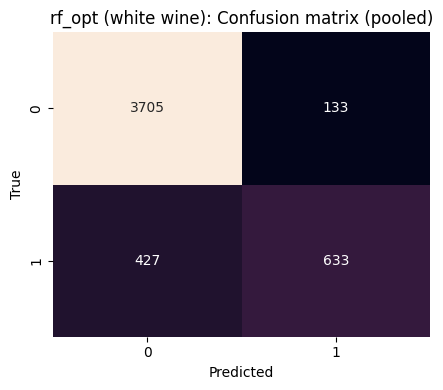

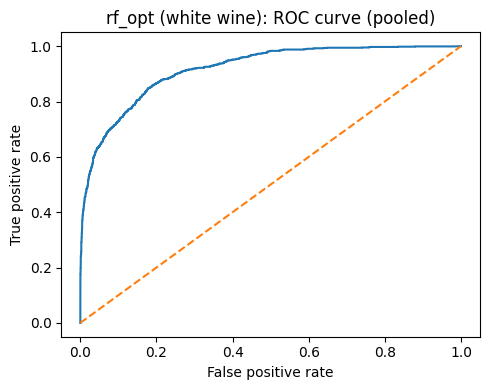

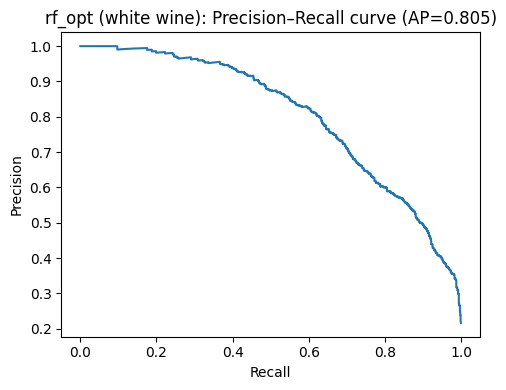

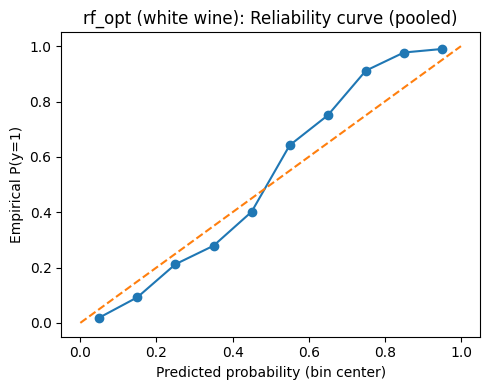


=== xgb_opt using xgb_optuna best params ===
{'n_estimators': 915, 'max_depth': 9, 'learning_rate': 0.019328409338512265, 'subsample': 0.7342517888958519, 'colsample_bytree': 0.7460847077484792, 'min_child_weight': 0.506021345844454, 'gamma': 0.3420119388380192, 'reg_lambda': 0.14160120804034515, 'reg_alpha': 4.538320873914427e-06}
xgb_opt Fold 1: ACC=0.8949 AUC=0.9253 | fit=0.524s pred=0.004s
xgb_opt Fold 2: ACC=0.8796 AUC=0.9059 | fit=0.486s pred=0.006s
xgb_opt Fold 3: ACC=0.8959 AUC=0.9252 | fit=0.560s pred=0.005s
xgb_opt Fold 4: ACC=0.8641 AUC=0.8945 | fit=0.498s pred=0.005s
xgb_opt Fold 5: ACC=0.8825 AUC=0.9167 | fit=0.497s pred=0.005s

xgb_opt 5-fold CV: ACC=0.8834±0.0130, AUC=0.9135±0.0133
Timing: fit=0.51s±0.03, predict=0.00s±0.00
-------------------------------------------------------


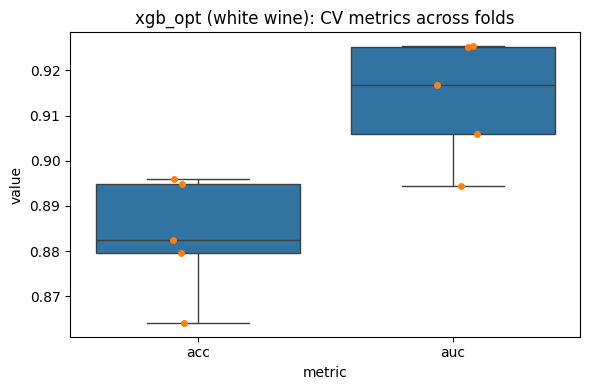

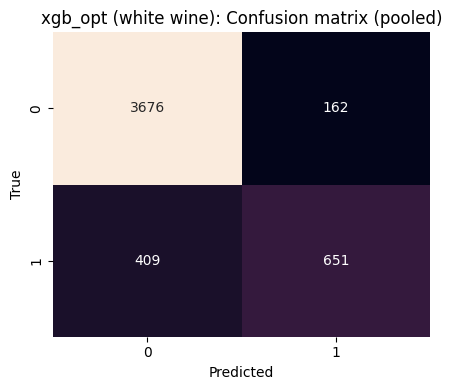

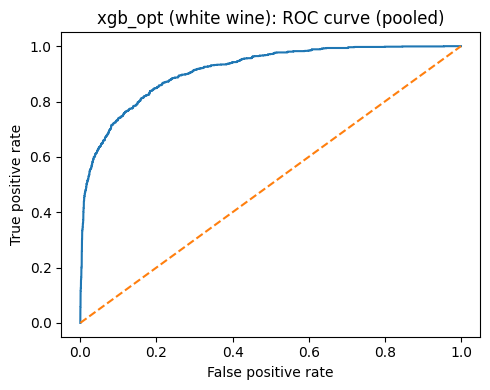

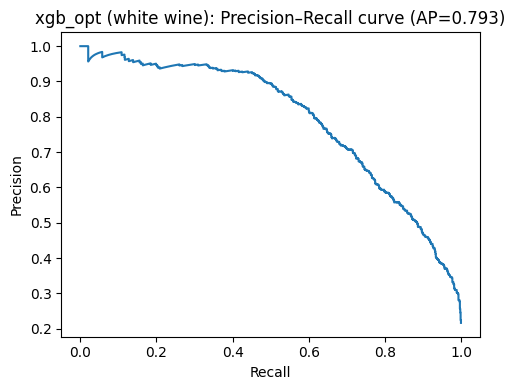

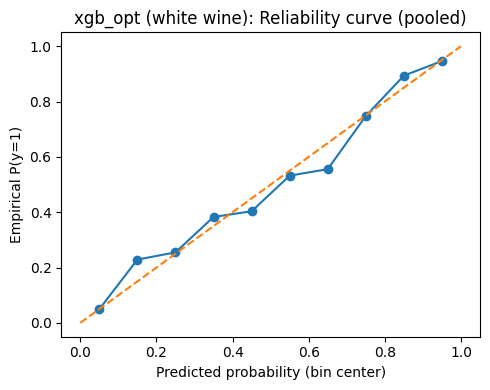


=== lgbm_opt using lgbm_optuna best params ===
{'n_estimators': 564, 'learning_rate': 0.017233829204633608, 'num_leaves': 238, 'min_child_samples': 12, 'subsample': 0.9402710663415308, 'colsample_bytree': 0.782500582726093, 'reg_lambda': 0.04027861684544178, 'min_split_gain': 0.004342259798436383}
lgbm_opt Fold 1: ACC=0.8878 AUC=0.9305 | fit=2.555s pred=0.009s
lgbm_opt Fold 2: ACC=0.8867 AUC=0.9132 | fit=2.372s pred=0.010s
lgbm_opt Fold 3: ACC=0.8918 AUC=0.9273 | fit=2.547s pred=0.009s
lgbm_opt Fold 4: ACC=0.8682 AUC=0.8927 | fit=2.807s pred=0.011s
lgbm_opt Fold 5: ACC=0.8866 AUC=0.9183 | fit=2.398s pred=0.011s

lgbm_opt 5-fold CV: ACC=0.8842±0.0092, AUC=0.9164±0.0150
Timing: fit=2.54s±0.17, predict=0.01s±0.00
-------------------------------------------------------


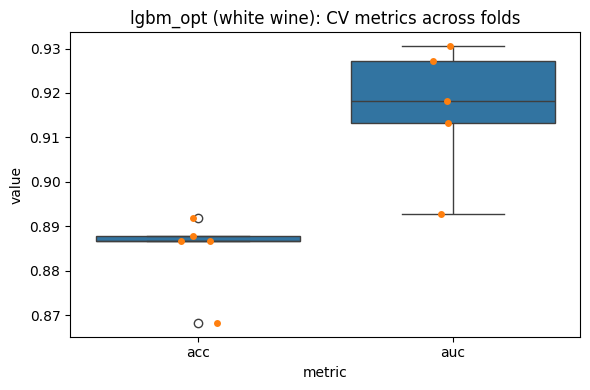

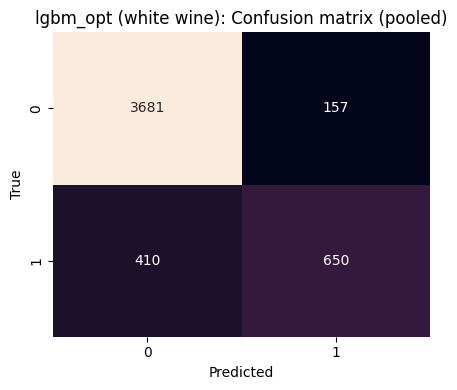

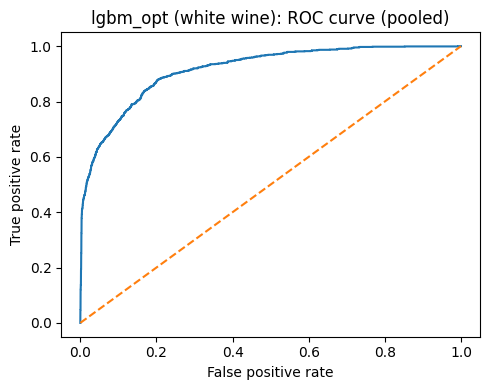

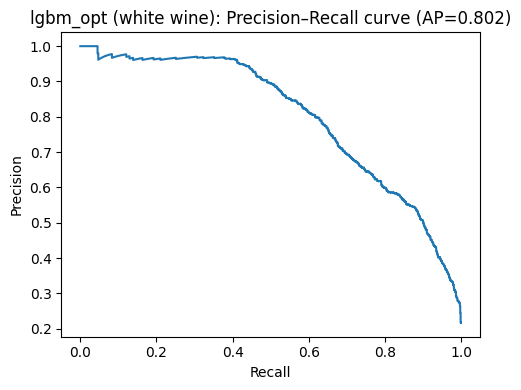

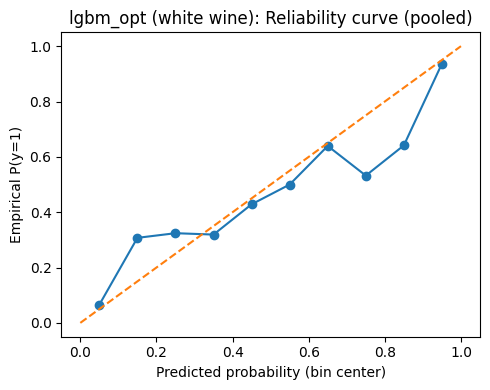


=== cat_opt using cat_optuna best params ===
{'iterations': 1764, 'depth': 10, 'learning_rate': 0.006521349204060195, 'l2_leaf_reg': 0.03055204155999041, 'random_strength': 0.41542311665958837, 'bagging_temperature': 1.5619428550992758}
cat_opt Fold 1: ACC=0.8918 AUC=0.9279 | fit=21.886s pred=0.005s
cat_opt Fold 2: ACC=0.8796 AUC=0.9179 | fit=22.339s pred=0.004s
cat_opt Fold 3: ACC=0.8990 AUC=0.9319 | fit=21.884s pred=0.004s
cat_opt Fold 4: ACC=0.8672 AUC=0.9067 | fit=22.056s pred=0.005s
cat_opt Fold 5: ACC=0.8805 AUC=0.9209 | fit=22.075s pred=0.005s

cat_opt 5-fold CV: ACC=0.8836±0.0122, AUC=0.9210±0.0098
Timing: fit=22.05s±0.19, predict=0.00s±0.00
-------------------------------------------------------


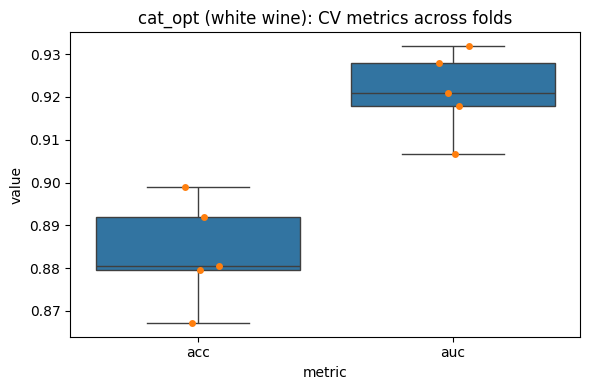

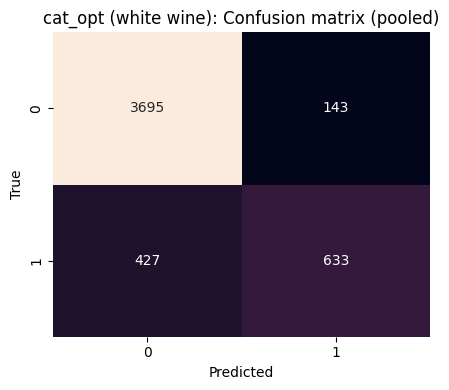

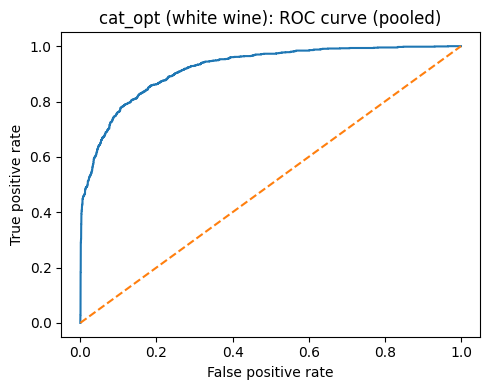

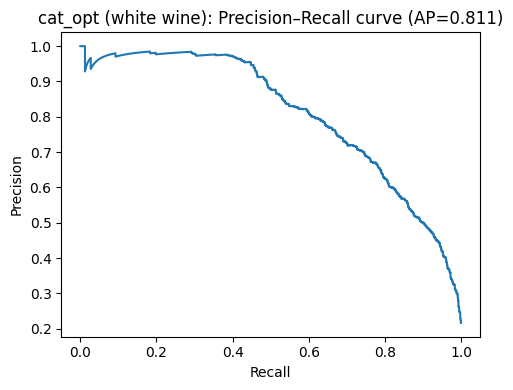

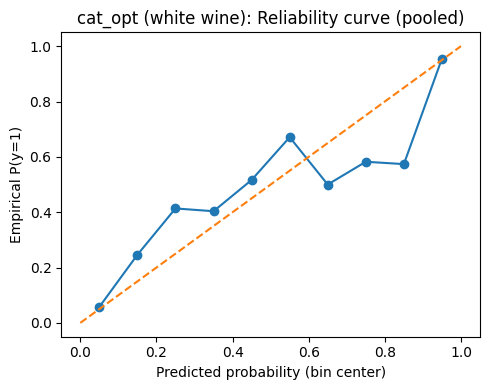

In [24]:

opt_models = {
    "rf_opt":  ("rf_optuna",  lambda p: RandomForestClassifier(random_state=20, n_jobs=-1, **p)),
    "xgb_opt": ("xgb_optuna", lambda p: XGBClassifier(
        random_state=20, n_jobs=-1, eval_metric="logloss", tree_method="hist", **p
    )),
    "lgbm_opt": ("lgbm_optuna", lambda p: LGBMClassifier(random_state=20, n_jobs=-1, verbose=-1, **p)),
    "cat_opt": ("cat_optuna", lambda p: CatBoostClassifier(random_seed=20, verbose=False, loss_function="Logloss", **p)),
}

for run_key, (opt_key, builder) in opt_models.items():
    if opt_key not in MODEL_RESULTS:
        print(f"Skipping {run_key}: missing MODEL_RESULTS['{opt_key}'] (run Optuna first).")
        continue

    best_params = MODEL_RESULTS[opt_key]["best_params"]
    print(f"\n=== {run_key} using {opt_key} best params ===")
    print(best_params)

    run_cv(run_key, lambda bp=best_params: builder(bp))

    MODEL_RESULTS[run_key]["dataset"] = dataset_label

    plot_model_results(run_key)


In [25]:
rows = []
for name, res in MODEL_RESULTS.items():
    cv = res.get("cv_metrics_df", None)
    if cv is None or getattr(cv, "empty", True):
        continue
    if not {"acc", "auc"}.issubset(set(cv.columns)):
        continue

    rows.append({
        "model": name,
        "dataset": res.get("dataset", "unknown"),
        "acc_mean": cv["acc"].mean(),
        "acc_std": cv["acc"].std(ddof=1),
        "auc_mean": cv["auc"].mean(),
        "auc_std": cv["auc"].std(ddof=1),
        "fit_s_mean": cv["fit_s"].mean() if "fit_s" in cv.columns else np.nan,
        "pred_s_mean": cv["pred_s"].mean() if "pred_s" in cv.columns else np.nan,
        "n_folds": int(cv.shape[0]),
    })

summary_df = pd.DataFrame(rows)

for c in ["acc_mean", "acc_std", "auc_mean", "auc_std", "fit_s_mean", "pred_s_mean"]:
    summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce")

# sort by AUC mean
summary_df = summary_df.sort_values("auc_mean", ascending=False).reset_index(drop=True)

display(summary_df.style.format({
    "acc_mean": "{:.4f}",
    "acc_std": "{:.4f}",
    "auc_mean": "{:.4f}",
    "auc_std": "{:.4f}",
    "fit_s_mean": "{:.3f}",
    "pred_s_mean": "{:.3f}",
}))


,model,dataset,acc_mean,acc_std,auc_mean,auc_std,fit_s_mean,pred_s_mean,n_folds
0,tabicl,white wine,0.8853,0.0105,0.9317,0.0123,0.518,2.881,5
1,tabpfn,white wine,0.8808,0.0093,0.9229,0.0144,0.247,1.938,5
2,cat_opt,white wine,0.8836,0.0122,0.9210,0.0098,22.048,0.004,5
3,rf_opt,white wine,0.8857,0.0120,0.9177,0.0125,1.301,0.209,5
4,rf,white wine,0.8814,0.0065,0.9164,0.0110,0.286,0.052,5
5,lgbm_opt,white wine,0.8842,0.0092,0.9164,0.0150,2.536,0.010,5
6,xgb_opt,white wine,0.8834,0.0130,0.9135,0.0133,0.513,0.005,5
7,xgb,white wine,0.8701,0.0165,0.8979,0.0161,0.047,0.002,5
8,lgbm,white wine,0.8677,0.0094,0.8978,0.0147,0.082,0.002,5
9,cat,white wine,0.8583,0.0079,0.8947,0.0128,2.326,0.002,5


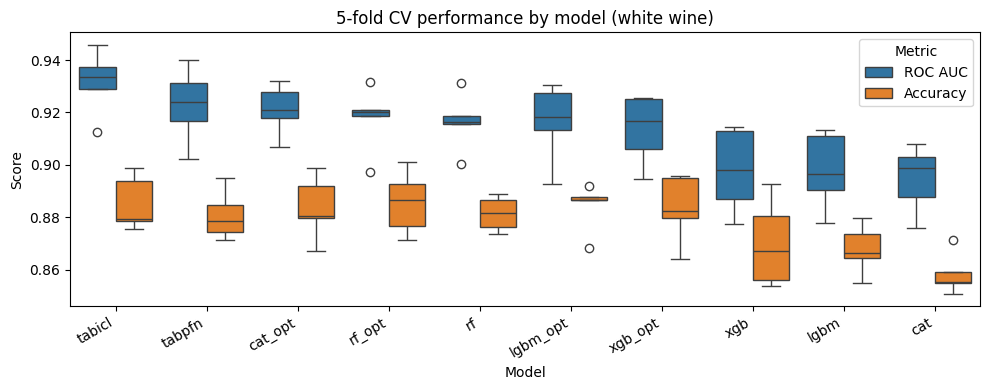

In [26]:
model_order = summary_df["model"].tolist()

rows = []
for name, res in MODEL_RESULTS.items():
    cv = res.get("cv_metrics_df")
    if cv is None or getattr(cv, "empty", True):
        continue
    if not {"fold", "acc", "auc"}.issubset(set(cv.columns)):
        continue

    tmp = cv.copy()
    tmp["model"] = name
    tmp["dataset"] = res.get("dataset", "unknown")
    rows.append(tmp)

cv_all = pd.concat(rows, ignore_index=True)

m_long = cv_all.melt(
    id_vars=["dataset", "model", "fold"],
    value_vars=["acc", "auc"],
    var_name="metric",
    value_name="value",
)

metric_names = {"acc": "Accuracy", "auc": "ROC AUC"}
m_long["metric"] = m_long["metric"].map(metric_names)

# enforce categorical order for x-axis
m_long["model"] = pd.Categorical(m_long["model"], categories=model_order, ordered=True)
m_long = m_long.sort_values("model")

plt.figure(figsize=(max(10, 0.7 * len(model_order)), 4))
ax = sns.boxplot(data=m_long, x="model", y="value", hue="metric", order=model_order)

ax.set_xlabel("Model")
ax.set_ylabel("Score")
datasets = ", ".join(sorted(m_long["dataset"].unique()))
ax.set_title(f"5-fold CV performance by model ({datasets})")

ax.legend(title="Metric", loc="upper right", frameon=True)

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


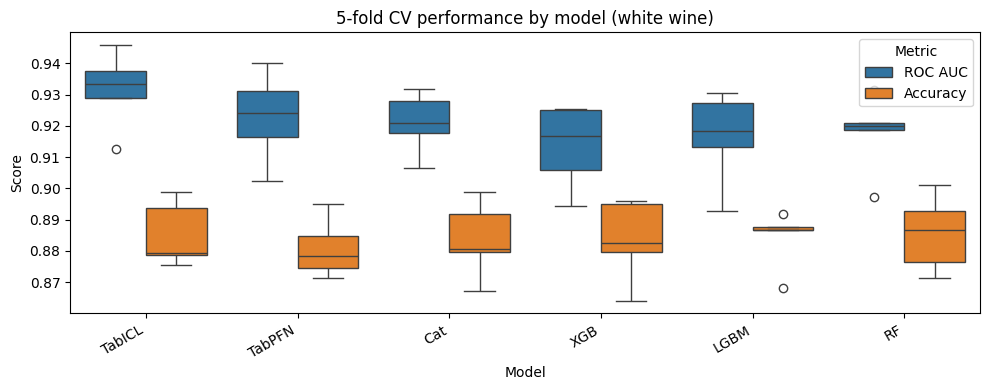

In [30]:
# Tree-only (opt versions) + TabPFN/TabICL

names = {
    "tabicl": "TabICL",
    "tabpfn": "TabPFN",
    "rf_opt": "RF",
    "xgb_opt": "XGB",
    "lgbm_opt": "LGBM",
    "cat_opt": "Cat",
}

wanted_keys = ["tabicl", "tabpfn", "cat_opt", "xgb_opt", "lgbm_opt", "rf_opt"]
present_keys = [k for k in wanted_keys if k in MODEL_RESULTS]
model_order = [names[k] for k in present_keys]

rows = []
for key in present_keys:
    res = MODEL_RESULTS[key]
    cv = res.get("cv_metrics_df")
    if cv is None or getattr(cv, "empty", True):
        continue
    if not {"fold", "acc", "auc"}.issubset(set(cv.columns)):
        continue

    tmp = cv.copy()
    tmp["model"] = names[key]
    tmp["dataset"] = res.get("dataset", "unknown")
    rows.append(tmp)

cv_all = pd.concat(rows, ignore_index=True)

m_long = cv_all.melt(
    id_vars=["dataset", "model", "fold"],
    value_vars=["acc", "auc"],
    var_name="metric",
    value_name="value",
)

# ROC AUC first, Accuracy second
metric_order = ["auc", "acc"]
metric_names = {"acc": "Accuracy", "auc": "ROC AUC"}
m_long["metric"] = pd.Categorical(m_long["metric"], categories=metric_order, ordered=True)
m_long["metric"] = m_long["metric"].map(metric_names)

m_long["model"] = pd.Categorical(m_long["model"], categories=model_order, ordered=True)
m_long = m_long.sort_values(["model", "metric"])

plt.figure(figsize=(max(10, 0.7 * len(model_order)), 4))
ax = sns.boxplot(
    data=m_long,
    x="model",
    y="value",
    hue="metric",
    order=model_order,
    hue_order=[metric_names[m] for m in metric_order],
)

ax.set_xlabel("Model")
ax.set_ylabel("Score")
datasets = ", ".join(sorted(m_long["dataset"].unique()))
ax.set_title(f"5-fold CV performance by model ({datasets})")

ax.legend(title="Metric", loc="upper right", frameon=True)

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()
